## Nonlinear pulse propagation - Example

Will use parameters from Marc and Alireza's paper[1] to validate the code.

[1]M. Jankowski et al., “Temporal Simultons in Optical Parametric Oscillators,” Phys. Rev. Lett., vol. 120, no. 5, p. 053904, Feb. 2018, doi: 10.1103/PhysRevLett.120.053904.

We begin by the typical Python imports.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
import scipy
import copy
from matplotlib import cm
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
from util import sech

In [2]:
# Change size of plots (for wider plots)
plt.rcParams['figure.figsize'] = [10, 5]

## Units
We'll work mainly in the following units:

time = fs <br>
frequency = PHz (1/time) <br>
distance = mm

We'll import the speed of light from Scipy and scale it so it's in units of mm/fs

In [3]:
from scipy.constants import pi, c
c = c*1e-12; #mm/fs, [Freq]=PHz

## Time and Frequency domain windows

Now we need to determine an FFT size $N$, this will be the common size for the time and frequency axis in our simulations. We also need to select how large the time window $2 T_{\mathrm{max}}$ for our simulations will be. The time window needs to be large enough so that pulses don't reach the edge of the domain at any point. Since we'll usually pick a reference frame that moves with one of the pulses, then how much the other pulses travel depends on the respective group velocity mismatch. The sampling period $\Delta t$ will be determined by the size of the window and the number of points; Nyquist criteria must be satisfied as usual.

Once the number of points and time-window has been selected, the frequency grid is fixed by the FFT, with a frequency resolution
$$ F_s = \frac{1}{N \Delta t},$$
the minimum frequency is 0 while the maximum frequency is
$$ F_{\mathrm{max}} = \pm \frac{1}{2\Delta t}.$$
The maximum frequency should alway be below the desired absolute carrier frequency. So the longest wavelength allowed becomes:
$$ \lambda_{\mathrm{max}} = \frac{c}{F_{\mathrm{max}}} = 2c\Delta t $$

In [4]:
NFFT = 2**8 #Number of FFT points

Tmax = 500 #(fs) (window will go from -Tmax to Tmax)
t = np.linspace(-Tmax, Tmax, NFFT, endpoint=False)
dt = t[1]-t[0] #Sampling period
print('Sampling Rate =', dt, 'fs')

f = fftfreq(NFFT, dt) #PHz
omega = 2*pi*f
Fmax = abs(np.amin(f)) #PHz
print('Frequency Resolution = %0.3f THz' %(f[1]*1e3))
print('Maximum frequency = %0.3f THz' %(Fmax*1e3))
print('Longest wavelength allowed = %0.3f um' %(c/Fmax*1e3))

Sampling Rate = 3.90625 fs
Frequency Resolution = 1.000 THz
Maximum frequency = 128.000 THz
Longest wavelength allowed = 2.342 um


## Signal pulse creation

1.159e-17 fJ
1.159e-17 fJ


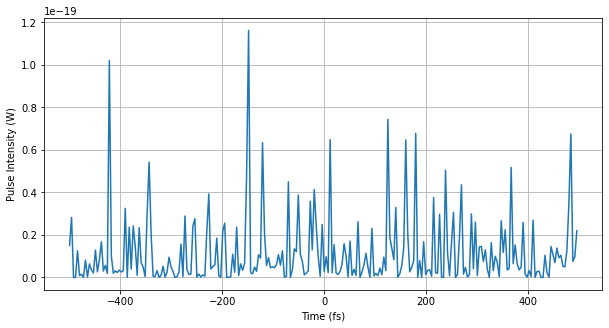

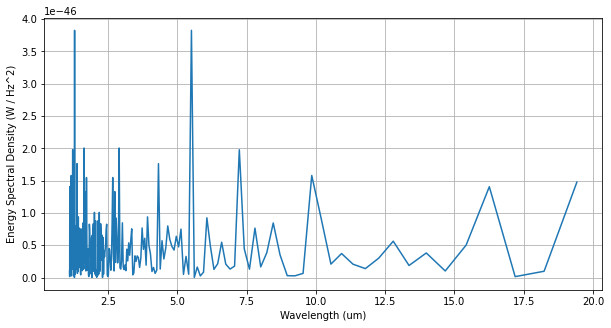

In [5]:
wla = 2.090e-3 #signal wavelength (mm)
wa = 2*pi*c/wla #Central angular frequency for pulse "a"
noise = 1e-10*np.random.normal(size=NFFT)
signal_in = nlo.pulse(t, noise, wla*1e3)

signal_in.plot_magsq_vs_time()
signal_in.plot_ESD_vs_wavelength()
print(format(signal_in.energy_td()*1e15, '0.3e'), 'fJ')
print(format(signal_in.energy_fd()*1e15, '0.3e'), 'fJ')

## Pump pulse creation

2.200e+00 nJ
2.200e+00 nJ


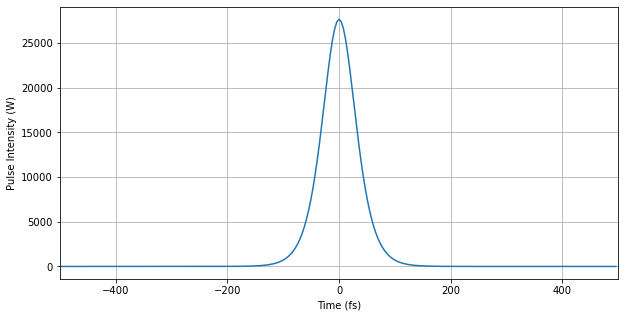

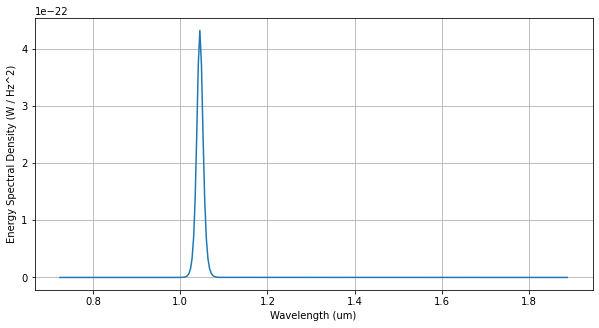

In [6]:
#Parameters
wlb = wla/2 #pump wavelength (mm)
pump_pwr = 0.55 #Average pump power (W)
Tp = 70 #Input pulse width (fs)

#Pulse creation
tau = Tp/1.76
pulse = np.sqrt(0.88*4e6/Tp*pump_pwr)*sech(t/tau)
pump_in = nlo.pulse(t, pulse, wlb*1e3)

pump_in.plot_magsq_vs_time(xlim=[-500,500])
pump_in.plot_ESD_vs_wavelength()
print(format(pump_in.energy_td()*1e9, '0.3e'), 'nJ')
print(format(pump_in.energy_fd()*1e9, '0.3e'), 'nJ')

## Feedback Loop

Now we create the linear element that represents the feedback loop. Let's make if a function of the detuning $\delta T$ so we can change that easily later on.

In [7]:
def feedback_loop(dT):
    '''
    dT: Detuning in fs
    '''
    #Output coupler loss
    Co_loss = 1-0.65  
    
    #Cavity dispersion parameters
    phi2 = 25 #25*2
    phi3 = 76
    phi4 = -13020
    phi5 = 983328

    #Feedback loop
    deltaphi = (phi2/2)*omega**2 + (phi3/6)*omega**3 + (phi4/24)*omega**4 + (phi5/120)*omega**5
    l = c*dT/wlb #Detuning parameter l
    phi = pi*l + dT*omega + deltaphi

    #Linear element representing this feedback path in the freq domain
    fb = np.sqrt(Co_loss)*np.exp(1j*phi)
    
    return fb

## Nonlinear element

Similarly, we create a nonlinear element. Here I'll make it a function of the step size $h$ so I can run some convergence tests later.

In [8]:
def nle(h):
    '''
    h: step size in mm
    '''
    
    #Beam waist of signal (mm)
    Ws = 14e-3 
    
    #Crystal dispersion
    alpha_a = 0.00691 #loss for signal in crystal (1/mm)
    alpha_b = 0.00691 #loss for pump in crystal (1/mm)
    u = 112.778 #Group velocity mismatch (fs/mm)
    b2a = -53.64 #second order GVD signal (fs^2/mm)
    b3a = 756.14 #third order GVD signal (fs^3/mm)
    b4a = -2924.19 #fourth order GVD signal (fs^4/mm)
    b2b = 240.92 #second order GVD pump (fs^2/mm)
    b3b = 211.285 #second order GVD pump (fs^3/mm)
    b4b = -18.3758 #second order GVD pump (fs^4/mm)
    deff = 2/pi*16e-9 #effective nonlinear coefficient (mm/V)
    na = 2.2333# refractive index at signal
    nb = 2.1935# refractive index at pump

    #Dispersion functions
    Da = alpha_a/2 - 1j*b2a*omega**2/2 - 1j*b3a*omega**3/6 - 1j*b4a*omega**4/24
    Db = alpha_b/2 - 1j*u*omega - 1j*b2b*omega**2/2 - 1j*b3b*omega**3/6 - 1j*b4b*omega**4/24

    #Crystal parameters
    L = 1 #mm

    #Nonlinear coupling
    nlc = np.sqrt(2*377)*deff*(omega+wa)/(Ws*na*c*np.sqrt(pi*nb))

    crystal = nlo.nonlinear_element(L=L, h=h, Da=Da, Db=Db, nlc=nlc)
    
    return crystal

## OPO

Next I create a function for the OPO. It receives the signal and pump pulses, as well as the nonlinear element, the feedback loop, and the number for rountrips to be simulated.

In [9]:
def OPO(signal_in, pump_in, nl_element, feedback, N=250):

    #Output pulses
    signal = copy.deepcopy(signal_in)
    pump = copy.deepcopy(pump_in)
    
    #Variables to save roundtrip evolution
    signal_evolution = np.zeros([N, pump.NFFT])
    signal_energy_evol = np.zeros(N)
    pump_energy_evol = np.zeros(N)
    
    for kn in range(N):
        [signal, pump] =  nl_element.propagate(signal, pump)
        
        #Save the signal evolution as well as the signal and pump energies
        signal_evolution[kn,:] = (np.abs(signal.e)/np.max(np.abs(signal.e)))**2
        signal_energy_evol[kn] = signal.energy_td()
        pump_energy_evol[kn] = pump.energy_td()
        
        #Apply feedback
#         signal.update_fd(signal.E * feedback)
        feedback.propagate(signal)
        
        if (kn+1)%50==0:
            print('Completed roundtrip ' + str(kn+1))
    
    return signal, pump, signal_evolution, signal_energy_evol, pump_energy_evol

In [10]:
Nrt = 300
dT = 0
fb = feedback_loop(dT)
fb = nlo.linear_element(fb)
crystal = nle(h = 1/50)

start = time.time();
signal, pump, signal_evolution, signal_energy_evol, pump_energy_evol = OPO(signal_in, pump_in, crystal, fb, N=Nrt)
elapsed = time.time() - start;
print('Time elapsed = ' + str(round(elapsed,5)) + ' seconds')

Completed roundtrip 50
Completed roundtrip 100
Completed roundtrip 150
Completed roundtrip 200
Completed roundtrip 250
Completed roundtrip 300
Time elapsed = 3.08725 seconds


In [11]:
# Nrt = 300
# dT = 0
# fb = feedback_loop(dT)
# crystal = nle(h = 1/50)
# start = time.time();
# signal, pump, signal_evolution, signal_energy_evol, pump_energy_evol = OPO(signal_in, pump_in, crystal, fb, N=Nrt)
# elapsed = time.time() - start;
# print('Time elapsed = ' + str(round(elapsed,5)) + ' seconds')

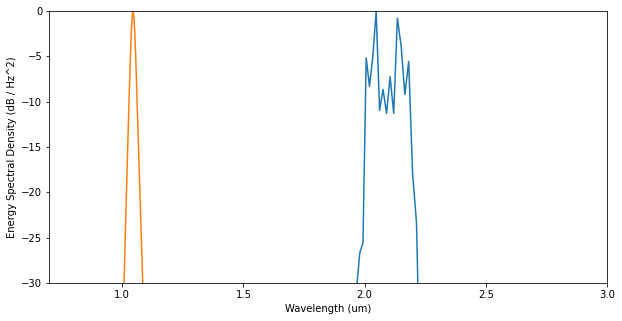

In [12]:
fig = plt.figure(); ax1 = fig.add_subplot(111)
signal.plot_ESD_dB_wavelength(ax1=ax1,xlim=[0.7,3], ylim=[-30,0])
pump.plot_ESD_dB_wavelength(ax1=ax1, xlim=[0.7,3], ylim=[-30,0])

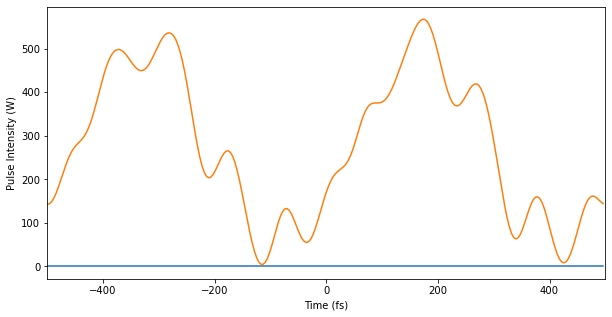

In [13]:
fig = plt.figure(); ax1 = fig.add_subplot(111)
signal.plot_magsq_vs_time(xlim=[-500,500], ax1=ax1)
pump.plot_magsq_vs_time(xlim=[-500,500], ax1=ax1)

(-300.0, 200.0)

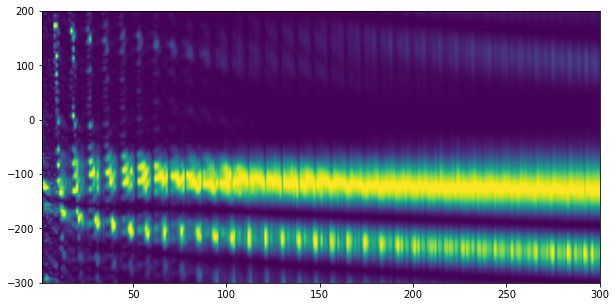

In [14]:
X,Y = np.meshgrid(np.arange(1,Nrt+1), t)
plt.contourf(X, Y, np.transpose(signal_evolution), 100)
plt.ylim([-300,200])

Now let's look at how the energy of the signal and pump change vs round trips:

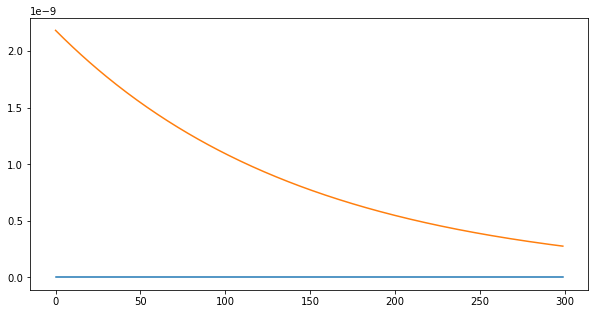

In [15]:
plt.plot(np.arange(Nrt), signal_energy_evol)
plt.plot(np.arange(Nrt), pump_energy_evol)

## Detuning sweep

In [16]:
# Nrt = 1000
# dT_array = np.arange(-25,10.1,0.25)
# signal = np.empty( dT_array.shape , dtype=object)
# k = 0
# for dT in dT_array:

#     #Feedback loop
#     l = c*dT/wlb #Detuning parameter l
#     phi = pi*l + dT*Omega + deltaphi
#     fb = np.sqrt(Co_loss)*np.exp(1j*phi)

#     #Linear element representing this feedback path
#     fb = nlo.linear_element(fb)
    
#     print('Detuning = %0.2f' %(dT))
#     signal[k], pump, signal_evol, signal_energy, pump_energyl = nlo.OPO(signal_in, pump_in, crystal, fb, N=Nrt)
    
#     k = k+1

In [17]:
# signal_spec = np.zeros([Omega.size, dT_array.size])
# for k in np.arange(dT_array.size):
#     esd_rel = 10*np.log10((signal[k].esd/np.amax(signal[k].esd)))
#     signal_spec[:,k] = fftshift(esd_rel)

In [18]:
# X,Y = np.meshgrid(fftshift(Omega)*1000, dT_array)

In [19]:
# plt.pcolormesh(X, Y, (np.transpose(signal_spec)), vmin=-30, vmax=0)
# plt.xlim([-500,500]);

In [20]:
# plt.pcolormesh(X, Y, (np.transpose(signal_spec)), vmin=-30, vmax=0, norm=Normalize(vmin=-30, vmax=0, clip=False))
# plt.xlim([-500,500]);